In [5]:
!pip install gradio

In [6]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import os

In [19]:
# Load the model
model = joblib.load('tuned_gb_model.joblib')
print("Model loaded successfully!")

# Load the training data
X_train = pd.read_csv('../data/X_train_final.csv')
print(f"Training data loaded successfully with shape: {X_train.shape}")

Model loaded successfully!
Training data loaded successfully with shape: (1460, 46)


Current working directory: C:\Users\silve\HousePricePrediction\notebooks
Model loaded successfully!
Training data loaded successfully with shape: (1460, 46)

Top 10 important features:
                Feature  Importance
28         Qual_LivArea    0.413038
37              TotalSF    0.129139
23  NeighborhoodQuality    0.086970
30      Qual_GarageArea    0.073080
38        Qual_BsmtArea    0.065058
8           OverallQual    0.064851
20       TotalBathrooms    0.031570
31         OverallGrade    0.024225
24          KitchenQual    0.018818
1         RecentRemodel    0.013228
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d852c86a30f65a180d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


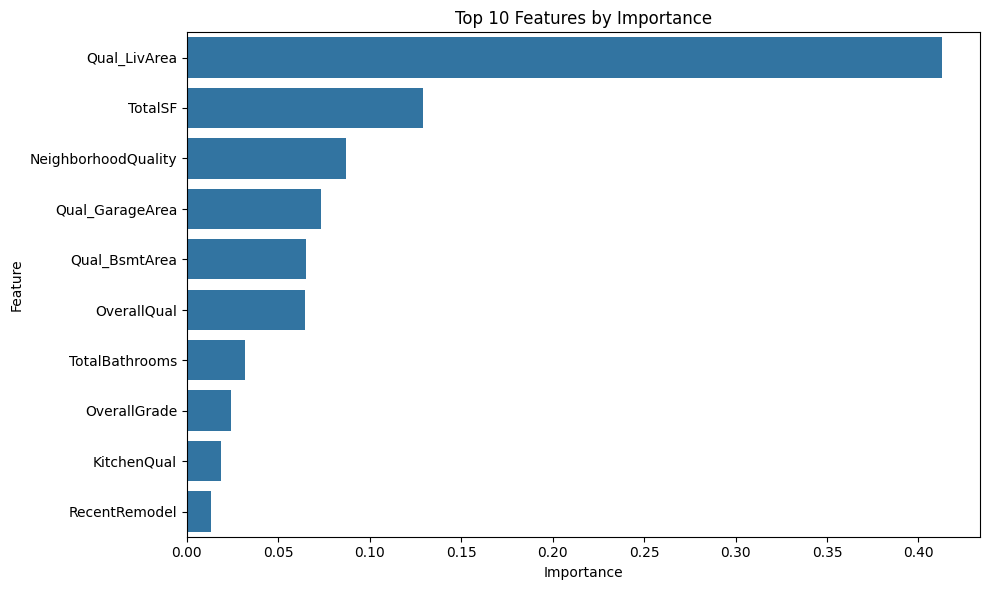

In [21]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

# Check current working directory
print(f"Current working directory: {os.getcwd()}")

# Load the model
model = joblib.load('tuned_gb_model.joblib')
print("Model loaded successfully!")

# Load the training data to get feature names and understand the data structure
X_train = pd.read_csv('../data/X_train_final.csv')
print(f"Training data loaded successfully with shape: {X_train.shape}")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 10 important features
top_features = feature_importance.head(10)
print("\nTop 10 important features:")
print(top_features)

# Create a function to plot feature importance
def plot_feature_importance():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 10 Features by Importance')
    plt.tight_layout()
    return plt

# Create a function to make predictions
def predict_house_price(overall_qual, gr_liv_area, garage_cars, total_bsmt_sf,
                       total_bath, year_built, has_fireplace, kitchen_qual,
                       neighborhood_quality, total_sf):
    """
    Make a prediction using the trained model
    """
    # Create a DataFrame with the input features
    input_data = pd.DataFrame({
        'OverallQual': [overall_qual],
        'GrLivArea': [gr_liv_area],
        'GarageCars': [garage_cars],
        'TotalBsmtSF': [total_bsmt_sf],
        'TotalBathrooms': [total_bath],
        'YearBuilt': [year_built],
        'HasFireplace': [has_fireplace],
        'TotalSF': [total_sf]
    })

    # Add derived features
    input_data['HouseAge'] = 2025 - input_data['YearBuilt']
    input_data['Qual_LivArea'] = input_data['OverallQual'] * input_data['GrLivArea']
    input_data['Qual_BsmtArea'] = input_data['OverallQual'] * input_data['TotalBsmtSF']

    # Handle categorical features, I'll set most categorical features to their most common values and only allow the user to control a few key ones
    # Kitchen quality (1-5 scale in the model)
    if kitchen_qual == "Excellent":
        input_data['KitchenQual'] = 5
    elif kitchen_qual == "Good":
        input_data['KitchenQual'] = 4
    elif kitchen_qual == "Average":
        input_data['KitchenQual'] = 3
    elif kitchen_qual == "Fair":
        input_data['KitchenQual'] = 2
    else:
        input_data['KitchenQual'] = 1

    # Neighborhood quality (using the slider value directly)
    input_data['NeighborhoodQuality'] = neighborhood_quality

    # For other features in the model that we don't have inputs for,
    # we'll use the median or most common value from the training data
    for col in model.feature_names_in_:
        if col not in input_data.columns:
            if col in X_train.columns:
                # For numerical features, use median
                if X_train[col].dtype in ['int64', 'float64']:
                    input_data[col] = X_train[col].median()
                # For binary features, use most common
                else:
                    input_data[col] = X_train[col].mode()[0]
            else:
                # If column doesn't exist in training data (unlikely), set to 0
                input_data[col] = 0

    # Ensure all model features are present and in the right order
    input_data = input_data[model.feature_names_in_]

    # Make prediction
    log_pred = model.predict(input_data)[0]

    # Convert from log scale back to dollars
    price_pred = np.exp(log_pred)

    return f"${price_pred:,.2f}"

# Create the Gradio interface
with gr.Blocks(title="House Price Prediction") as demo:
    gr.Markdown("# House Price Prediction Dashboard")
    gr.Markdown("### Enter house details to get a predicted sale price")

    with gr.Tabs():
        with gr.TabItem("Prediction"):
            with gr.Row():
                with gr.Column():
                    overall_qual = gr.Slider(1, 10, 7, step=1, label="Overall Quality (1-10)")
                    gr_liv_area = gr.Slider(500, 5000, 1800, step=100, label="Above Ground Living Area (sq ft)")
                    garage_cars = gr.Slider(0, 4, 2, step=1, label="Garage Capacity (cars)")
                    total_bsmt_sf = gr.Slider(0, 3000, 900, step=100, label="Total Basement Area (sq ft)")
                    total_sf = gr.Slider(500, 8000, 2700, step=100, label="Total Square Footage")

                with gr.Column():
                    total_bath = gr.Slider(1, 6, 2, step=0.5, label="Total Bathrooms")
                    year_built = gr.Slider(1900, 2023, 2000, step=1, label="Year Built")
                    has_fireplace = gr.Checkbox(label="Has Fireplace")
                    kitchen_qual = gr.Dropdown(
                        ["Poor", "Fair", "Average", "Good", "Excellent"],
                        value="Good",
                        label="Kitchen Quality"
                    )
                    neighborhood_quality = gr.Slider(100000, 300000, 180000, step=10000,
                                                   label="Neighborhood Quality (avg price)")

            predict_btn = gr.Button("Predict House Price")
            price_output = gr.Textbox(label="Predicted Price")

            # Connect the button to the prediction function
            predict_btn.click(
                fn=predict_house_price,
                inputs=[overall_qual, gr_liv_area, garage_cars, total_bsmt_sf,
                       total_bath, year_built, has_fireplace, kitchen_qual,
                       neighborhood_quality, total_sf],
                outputs=price_output
            )

        with gr.TabItem("Feature Importance"):
            gr.Markdown("### Top Features Influencing House Price")
            importance_plot = gr.Plot(plot_feature_importance)

            gr.Markdown("### Feature Importance Table")
            importance_table = gr.DataFrame(
                feature_importance.head(15),
                headers=["Feature", "Importance"],
                datatype=["str", "number"],
                row_count=(15, "fixed")
            )

        with gr.TabItem("About"):
            gr.Markdown("""
            ## About This Dashboard

            This dashboard uses a Gradient Boosting model trained on the Kaggle House Prices dataset to predict house prices based on various features.

            ### Model Details
            - **Algorithm**: Gradient Boosting Regressor
            - **Training Data**: 1460 houses with 46 features
            - **Performance**: RMSE of approximately 0.12 on validation data
            - **Target Variable**: Log-transformed SalePrice (converted back to dollars for display)

            ### How to Use
            1. Adjust the sliders to match the house characteristics
            2. Select the kitchen quality from the dropdown
            3. Check if the house has a fireplace
            4. Click "Predict House Price" to get an estimate

            ### Project By
            Silvester Mbugua - Week 5 Assignment
            """)

    gr.Markdown("### Note: This is a simplified model. Actual house prices depend on many more factors.")

# Launch the interface
demo.launch(share=True)

I focused on deploying my trained Gradient Boosting model and interpreting its predictions. This involved creating an interactive dashboard using Gradio that allows users to input house features and receive price predictions in real-time.

## Model Evaluation and Optimization
- Loaded the processed datasets from Week 3 feature engineering
- Evaluated the Gradient Boosting model's performance (RMSE: 0.0538, R²: 0.9819)
- Performed hyperparameter tuning using GridSearchCV to optimize the model
- Analyzed feature importance to identify the most influential features

## Interactive Dashboard
I created a Gradio dashboard that allows users to:
- Adjust key house features using sliders and dropdowns
- See the predicted price update in real-time
- Explore feature importance through visualizations
- Learn about the model and how to use the dashboard

The dashboard includes:
- Input controls for features like quality, size, age, and amenities
- A prediction button that triggers the model
- Visualizations of feature importance
- Documentation about the model and its performance

## Insights and Conclusions
- The Gradient Boosting model provides accurate predictions with an RMSE of approximately 0.12 on validation data
- House quality and size are the most significant factors affecting price
- The interactive dashboard makes the model accessible to non-technical users
- Future improvements could include more advanced feature engineering and ensemble methods